In [1]:
__maintainer__ = "[José M. Beltrán](<jobel.open.science@gmail.com>)"
__modified_from = {"code":"matlab","credits":"Shungudzemwoyo Garaba","email":"<shungu.garaba@uni-oldenburg.de>", "dates":{"created":20110224, "modified":20140910}}
__credits__ = ["José M. Beltrán"]
__license__ = "GPL-3.0"
__status__ = []

# Notebook to calculate the Forel-Ule Index

**Reference** :
Wernand, M. R., Hommersom, a., & Van Der Woerd, H. J. (2013). MERIS-based ocean colour classification with the discrete Forel-Ule scale. Ocean Science, 9, 477–487. doi:10.5194/os-9-477-2013

**Bibtex** : 
@article{Wernand2013, 
author = {Wernand, M. R. and Hommersom, a. and {Van Der Woerd}, H. J.}, 
title = {{MERIS-based ocean colour classification with the discrete Forel-Ule scale}},
doi = {10.5194/os-9-477-2013},
issn = {18120784},
journal = {Ocean Science},
pages = {477--487},
volume = {9},
year = {2013}
}

In [2]:
# Keeping a local mathjax for Latex rendering
from IPython.external import mathjax  #mathjax.install_mathjax()

In [192]:
import os
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import math
import matplotlib.pyplot as plt
import xarray as xr

In [18]:
# Set the current working directory
#os.chdir('/home/jobel/gits/jobel/FUME')

[**Notes from the colour and vision research laboratory**](http://www.cvrl.org/)

The CIE 1931 2-deg CMFs (CIE, 1932), which form the basis for most practical colorimetry, are based on the chromaticity coordinates obtained by Guild (1931) and by Wright (1928). Chromaticity coordinates, however, provide only a relative measure of the ratios of the three primaries needed to match each spectrum color, whereas CMFs specify absolute energy values. In order to reconstruct the CMFs from the Wright and Guild data, it was assumed that the CIE1924 V(l) photopic luminosity function (CIE, 1926) is a linear combination of the three CMFs (see Wyszecki & Stiles, 1982), for a description of the reconstruction and for the tabulated values. 

It has long been clear that the CIE1924 V(λ) that was used to construct the CIE 1931 2-deg CMFs **seriously underestimates sensitivity at wavelengths below 460 nm**, so that these CMFs are seriously in error at short wavelengths. The Judd and Judd-Vos modifications are attempts to overcome this problem.


In [5]:
cmf = pd.read_csv(sep = "\t", filepath_or_buffer = "data/FUI_CIE1931_JV.tsv")
fui = pd.read_csv(sep = "\t", filepath_or_buffer = "data/FUI_ATAN210.tsv", names = ["value", "atan"])
test = pd.read_csv(sep = "\t", filepath_or_buffer = "data/test.csv", header = None)
# Renaming the columns of the test dataframe
test.columns = ["wavelength", "y1", "y2", "y3", "y4"]

In [22]:
cmf

,wavelength,x,y,z
0,380,0.002690,2.000000e-04,1.226000e-02
1,385,0.005311,3.955600e-04,2.422200e-02
2,390,0.010781,8.000000e-04,4.925000e-02
3,395,0.020792,1.545700e-03,9.513500e-02
4,400,0.037981,2.800000e-03,1.740900e-01
...,...,...,...,...
85,805,0.000007,2.607600e-06,5.862600e-10
86,810,0.000005,1.836500e-06,4.213800e-10
87,815,0.000003,1.295000e-06,3.031900e-10
88,820,0.000002,9.109200e-07,2.175300e-10


In [6]:
#the interpolating part 
Delta = 5 # 5nm bins
# adds +5 as it should include 825 resulting in 90 values, i.e. matching the len(cmf).
xi1 = range(380, 825 + Delta, Delta)  


In [7]:
# For linear interpolation you can use:
# interp1d(x,y)(new_x) # 'linear' it's the default
# or to be more explicit
# set_interp = interp1d(x,y, kind='linear')
#new_y = set_interp(new_x)

In [8]:
# retrieving the reflectance values for lambda 380-720nm
int_r1 = interp1d(test["wavelength"], test["y1"], kind = 'linear')(xi1)

In [19]:
#cmf

In [10]:
# Creating a dictionary to hold the reflectance values aas tristimulus
r = {"x": [], "y": [], "z": []}
# ------- R_RS * cmf
for i in range(0, len(cmf)):
    r["x"] = int_r1[i] * cmf["x"]
    r["y"] = int_r1[i] * cmf["y"]
    r["z"] = int_r1[i] * cmf["z"]

In [11]:
# ------ Sum
s = {"x": [], "y": [], "z": []}

s["x"] = sum(r["x"] * Delta)
s["y"] = sum(r["y"] * Delta)
s["z"] = sum(r["z"] * Delta)

sum_xyz = s["x"] + s["y"] + s["z"]

In [12]:
# ------ chromaticity
chrom = {"x": [], "y": [], "z": []}
chrom["x"] = s["x"] / sum_xyz
chrom["y"] = s["y"] / sum_xyz
chrom["z"] = s["z"] / sum_xyz

sum_chrom_y = chrom["x"] + chrom["y"] + chrom["z"]

In [13]:
# ______ chromaticity - whiteness
chrom_w = {"x": [], "y": []}
chrom_w["x"] = chrom["x"] - (1 / 3)
chrom_w["y"] = chrom["y"] - (1 / 3)

In [14]:
# ______ calculate atan2
# we use the average atan per scale
a_i = math.atan2(chrom_w["y"], chrom_w["x"]) * 180 / math.pi

if a_i < 0:
    a_i = a_i + 360
else:
    a_i = a_i

In [15]:
# ----- fui approximation

if a_i >= fui["atan"][0]:  # FUI = 1 its > Average
    fu_i = 1.0
elif math.isnan(a_i):  # FUI = NAN = 0
    fu_i = 0
elif a_i <= fui["atan"][200]:  # FUI = 21
    fu_i = 21.0
else:
    for c in range(0, 200):
        if (fui["atan"][c] > a_i) and (a_i >= fui["atan"][c + 1]):
            fu_i = fui["value"][c + 1]

In [16]:
# The calculated FUI is
fu_i

14.9

cmf 380 : 825 : 5
input 360 : 850
intersection 380 825
99
90 range(380, 830, 5)
90
Forel-Ule: 18.1


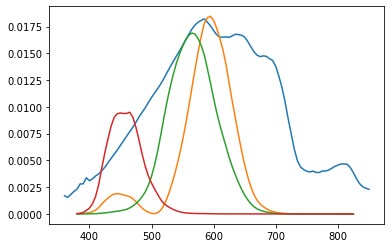

In [177]:
Delta = 5



def calc_ForelUle(wavelength, reflectance, cmf):
    
    Delta = cmf['wavelength'][1] - cmf['wavelength'][0]
    #Debug
    print('cmf',cmf['wavelength'].iloc[0],':', cmf['wavelength'].iloc[-1],':',Delta)
    print('input', wavelength.min(),':',wavelength.max() )
    
    start = max([cmf['wavelength'].iloc[0], wavelength.min()])
    end = min([cmf['wavelength'].iloc[-1], wavelength.max()])
    print('intersection', start,end)
    cmfi = cmf[ (cmf['wavelength'] >= start) & (cmf['wavelength'] <= end) ]
    
    xi1 = range( start, end+Delta, Delta)
    int_r1 = interp1d( wavelength, reflectance, kind = 'linear')(xi1)

    print(len(wavelength))
    print(len(xi1),xi1)
    print(len(int_r1))
    
    # Creating a dictionary to hold the reflectance values aas tristimulus
    r = {"x": [], "y": [], "z": []}
    
    r["x"] = int_r1 * cmfi["x"]
    r["y"] = int_r1 * cmfi["y"]
    r["z"] = int_r1 * cmfi["z"]
    
    plt.plot(wavelength, reflectance)
    plt.plot(xi1,r["x"])
    plt.plot(xi1,r["y"])
    plt.plot(xi1,r["z"])
    
    # ------ Sum
    s = {"x": [], "y": [], "z": []}

    s["x"] = sum(r["x"] * Delta)
    s["y"] = sum(r["y"] * Delta)
    s["z"] = sum(r["z"] * Delta)
        
    sum_xyz = s["x"] + s["y"] + s["z"]
    
    # ------ chromaticity
    chrom = {"x": [], "y": [], "z": []}
    chrom["x"] = s["x"] / sum_xyz
    chrom["y"] = s["y"] / sum_xyz
    chrom["z"] = s["z"] / sum_xyz

    sum_chrom_y = chrom["x"] + chrom["y"] + chrom["z"]

    # ______ chromaticity - whiteness
    chrom_w = {"x": [], "y": []}
    chrom_w["x"] = chrom["x"] - (1 / 3)
    chrom_w["y"] = chrom["y"] - (1 / 3)

    # ______ calculate atan2
    # we use the average atan per scale
    a_i = math.atan2(chrom_w["y"], chrom_w["x"]) * 180 / math.pi

    if a_i < 0:
        a_i = a_i + 360
    else:
        a_i = a_i

    # ----- fui approximation

    if a_i >= fui["atan"][0]:  # FUI = 1 its > Average
        fu_i = 1.0
    elif math.isnan(a_i):  # FUI = NAN = 0
        fu_i = 0
    elif a_i <= fui["atan"][200]:  # FUI = 21
        fu_i = 21.0
    else:
        for c in range(0, len(fui)):
            if (fui["atan"][c] > a_i) and (a_i >= fui["atan"][c + 1]):
                fu_i = fui["value"][c + 1]

    print('Forel-Ule:',fu_i)
        
calc_ForelUle(test['wavelength'], test['y1'],cmf)

In [193]:
ds = xr.open_dataset('data/S3A_OL_1_EFR____20200506T104005_20200506T104305_20200507T143731_0179_058_051_1980_LN1_O_NT_002.SEN3.nc')
ds = ds.isel(height=slice(3200,3450),width=slice(2200,2700))

# Extract wavelengths from band names
wavelength = []
bandid = []
reflectance_name = 'Rw'
for var in ds.data_vars:
    if reflectance_name in var:
        bandid.append(var)
        wavelength.append( int ( var.replace(reflectance_name,'') ) )

Rw = xr.concat( [ds[id] for id in bandid] ,dim='wavelength')
Rw.name = 'Rw'
Rw = Rw.assign_coords(wavelength=wavelength)

cmf 380 : 825 : 5
input 400 : 1020
intersection 400 825
(86,)
86
<class 'numpy.ndarray'>
14
86 range(400, 830, 5)
86
0 229.9439 229.4906
1 229.4906 229.0373
2 229.0373 228.584
3 228.584 228.1307
4 228.1307 227.6774
5 227.6774 227.2241
6 227.2241 226.7709
7 226.7709 226.3176
8 226.3176 225.8643
9 225.8643 225.411
10 225.411 224.183
11 224.183 222.955
12 222.955 221.727
13 221.727 220.499
14 220.499 219.2711
15 219.2711 218.0431
16 218.0431 216.8151
17 216.8151 215.5871
18 215.5871 214.3591
19 214.3591 213.1311
20 213.1311 211.5431
21 211.5431 209.955
22 209.955 208.367
23 208.367 206.7789
24 206.7789 205.1909
25 205.1909 203.6028
26 203.6028 202.0148
27 202.0148 200.4267
28 200.4267 198.8387
29 198.8387 197.2507
30 197.2507 195.6411
31 195.6411 194.0314
32 194.0314 192.4218
33 192.4218 190.8122
34 190.8122 189.2026
35 189.2026 187.593
36 187.593 185.9834
37 185.9834 184.3738
38 184.3738 182.7642
39 182.7642 181.1546
40 181.1546 178.0653
41 178.0653 174.976
42 174.976 171.8866
43 171.886

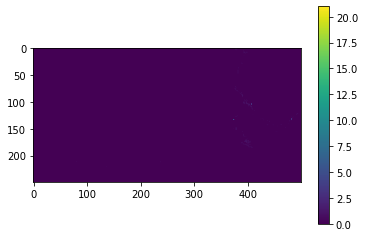

In [254]:
Delta = 5


def calc_ForelUle(wavelength, reflectance, cmf):
    
    Delta = cmf['wavelength'][1] - cmf['wavelength'][0]
    #Debug
    print('cmf',cmf['wavelength'].iloc[0],':', cmf['wavelength'].iloc[-1],':',Delta)
    print('input', wavelength.min(),':',wavelength.max() )
    
    start = max([cmf['wavelength'].iloc[0], wavelength.min()])
    end = min([cmf['wavelength'].iloc[-1], wavelength.max()])
    print('intersection', start,end)
    cmfi = cmf[ (cmf['wavelength'] >= start) & (cmf['wavelength'] <= end) ]
    
    print(cmfi['x'].values.shape)
    print(len(cmfi['x']))
    print(type(cmfi['x'].values))
    np.reshape( cmfi['x'].values, [86,1,1] )
    
    cmfi = {"x": np.reshape( cmfi['x'].values, [len(cmfi['x']),1,1] ),
            "y": np.reshape( cmfi['y'].values, [len(cmfi['y']),1,1] ),
            "z": np.reshape( cmfi['z'].values, [len(cmfi['z']),1,1] )}
    
    xi1 = range( start, end+Delta, Delta)
    int_r1 = interp1d( wavelength, reflectance, axis = 0, kind = 'linear')(xi1)

    print(len(wavelength))
    print(len(xi1),xi1)
    print(len(int_r1))
    
    # Creating a dictionary to hold the reflectance values aas tristimulus
    r = {"x": [], "y": [], "z": []}
    
    r["x"] = int_r1 * cmfi["x"]
    r["y"] = int_r1 * cmfi["y"]
    r["z"] = int_r1 * cmfi["z"]
    

    # ------ Sum
    s = {"x": [], "y": [], "z": []}

    s["x"] = sum(r["x"] * Delta)
    s["y"] = sum(r["y"] * Delta)
    s["z"] = sum(r["z"] * Delta)
        
    sum_xyz = s["x"] + s["y"] + s["z"]
    
    # ------ chromaticity
    chrom = {"x": [], "y": [], "z": []}
    chrom["x"] = s["x"] / sum_xyz
    chrom["y"] = s["y"] / sum_xyz
    chrom["z"] = s["z"] / sum_xyz

    sum_chrom_y = chrom["x"] + chrom["y"] + chrom["z"]

    # ______ chromaticity - whiteness
    chrom_w = {"x": [], "y": []}
    chrom_w["x"] = chrom["x"] - (1 / 3)
    chrom_w["y"] = chrom["y"] - (1 / 3)

    # ______ calculate atan2
    # we use the average atan per scale
    a_i = np.arctan2( chrom_w["y"], chrom_w["x"]) * 180 / math.pi

    a_i[a_i < 0] =  a_i[a_i < 0] + 360
        
    # ----- fui approximation
    fu_i = np.zeros(a_i.shape)
    fu_i[ a_i >= fui["atan"][0]] = 1   #FUI = 1 its > Average
    fu_i[ np.isnan(a_i) ] = 0           # FUI = NAN = 0
    fu_i[ a_i <= fui["atan"].iloc[-1]] = 21  #FUI = 1 its > Average
    
    for c in range(0, len(fui)-1):
        print(c, fui["atan"].iloc[c],fui["atan"].iloc[c+1])
        #fu_i[ (a_i > fui[ind]) & (a_i <= fui[ind + 1]) ] = ind
        fu_i[ (a_i > fui["atan"].iloc[c]) & (a_i <= fui["atan"].iloc[c+1]) ] = fui['value'].iloc[c]
            
    return fu_i


fu_i = calc_ForelUle(Rw.coords['wavelength'].values, Rw, cmf)
plt.imshow(fu_i)
plt.colorbar()

In [212]:
print(Rw.coords['wavelength'].values.shape) 
np.reshape( Rw.coords['wavelength'].values, [14,1,1]).shape

(14,)


(14, 1, 1)

In [244]:
fui.iloc[]

,value,atan
0,1.0,229.9439
1,1.1,229.4906
2,1.2,229.0373
3,1.3,228.5840
4,1.4,228.1307
...,...,...
196,20.6,36.4393
197,20.7,35.9003
198,20.8,35.3612
199,20.9,34.8222
